In [1]:
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from IPython.core.display import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
ref = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/ref/"
data = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/LTEE-clone-curated/"
storage = "C:/Users/Flora/Desktop/M2 Systèmes Complexes/Stage/Bioinfo/GenomeDiagram_tests/"

In [3]:
record = SeqIO.read(ref+'REL606.gbk', 'genbank')

In [4]:
def extract_positions(IS_name):
    '''Generates a dictionary listing the position of insertions that occured at some point in at least
    one of the clones of one of the populations (only one occurrence per position, even if it occured
    in different populations).'''
    
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(data) if isfile(join(data, f))] #listing all file names for the .gd files
    files = [] # creating a list that will first contain these names to be called, and later on open .gd files
    file_names = [] # list that will contain names as strings (kept as such for all the analysis)
    readlines_names = [] #list that will contain lists with the lines of each file (obtained via readlines())
    for i in onlyfiles: #fixing an error in the list of files (I don't know why it occurs) and filling the previously defined lists
        if len(i) < 30:
            files.append(i)
            file_names.append(i)
            readlines_names.append(i)
    
    
    for i in range(len(files)):
        files[i] = open(data+files[i],"r") #the list files becomes a list of open files
        readlines_names[i] = files[i].readlines() # the list readlines_names becomes a list of lists, with each list containing 
        #all the lines from one file
        
    insertion_positions = {} # Creating a dictionary to hold the positions of the insertions
    for i in range(len(file_names)): # for each file
        for line in readlines_names[i]: #we look at all the lines in the corresponding readlines_names entry
            line = line.split()
            if 'MOB' in line and IS_name in line: #if the line corresponds to a mutation linked to the IS
                insertion_positions[line[4]] = [line[4], line[6]] #we add an entry for this IS position to our dictionary
                # and save the orientation as well
    
    return insertion_positions
    

In [5]:
def extract_categories(insertion_positions):
    '''Uses the list of insertion sites generated by extract_positions() to extract the name of the genes that are
    interrupted by an IS insertion. The function yields a file with extended information about the genes (output_name) 
    and a file with only the gene names (gene_names_file). A given gene name can appear several times if several
    insertions into that gene were recorded.'''
    
    ref_file = open(ref+'NC_012967.ptt') #opening file containing info about CDS and COG classification
    ref_readlines = ref_file.readlines()
    ref_readlines = ref_readlines[3:] # we don't need the 3 first lines
    
    
    dict_genes_by_cat = {} #creating a dictionary to hold the category of each insertion
    
    for position in list(set(insertion_positions)):#for each position
        position_found = False
        for line_ref in ref_readlines: #we go through the ref file
            start_finish = line_ref.split()[0].split('..') #we get the beginning and end of the sequence
            if int(position) >= int(start_finish[0]) and int(position) <= int(start_finish[1]): 
                # if the IS insertion interrupts that sequence
                position_found = True
 
                if line_ref.split()[7][-1].isalpha(): #if there is a COG category attributed
                    dict_genes_by_cat[position] = line_ref.split()[7][-1] #we save it in the dict: {position: category}
                else:
                    dict_genes_by_cat[position] = 'unCOG' #otherwise we save 'unCOG as the category'
                    
        if not position_found:
            dict_genes_by_cat[position] = 'intergenic_region'
            #if we haven't found a sequence interrupted by the IS in the ref file: it likely interrupts an intergenic region
            
    return dict_genes_by_cat

In [6]:
def plot_GenomeDiagram(IS_name, category):
    '''Plots the location of insertions on the genome, with insertions into a given functional category highlighted in red.'''

    positions_IS = extract_positions(IS_name)
    dict_cat_IS = extract_categories(positions_IS)

    gd_diagram = GenomeDiagram.Diagram('REL606') #creating the diagram
    gd_track_for_features = gd_diagram.new_track(1, name = 'Annotated Features') #creating a track
    gd_feature_set = gd_track_for_features.new_set() #creating a feature set

    colors_dict = {'A': 'black', 'B':'black', 'C':'black', 'D':'black', 'E':'black', 'F':'black', 'G':'black', 'H':'black',
                   'I':'black', 'J':'black', 'K':'black', 'L':'black', 'M':'black', 'N':'black', 'O':'black',
                   'P':'black', 'Q':'black', 'R':'black', 'S':'black', 'T':'black' , 'U':'black', 'V':'black', 
                   'W':'black', 'Y':'black', 'Z':'black', 'unCOG':'black', 'intergenic_region':'grey'}
    
    colors_dict[category] = 'red' #the only features in red will be the genes of a given functional category

    len_IS = 1500 #could be changed for accuracy but not really necessary

    for insertion_position in list(dict_cat_IS.keys()): #for each insertion in the dictionary we generated
        IS_position = int(insertion_position)
        position_found = False

        for feature in record.features[1:]: # we go through the features
            if feature.type == 'CDS': #we look at coding sequences
                if 'join' not in str(feature.location): #getting rid of an annoying but unique anomaly in the features
                    start_position = int(str(feature.location).split(':')[0][1:]) #getting the start position of the CDS
                    end_position = int(str(feature.location).split(':')[1][:-4]) #getting the end position of the CDS
                    if IS_position >= start_position and IS_position <= end_position: # if the IS interrupts that CDS
                        position_found = True
                        color = colors_dict[dict_cat_IS[insertion_position]]
                        gd_feature_set.add_feature(feature, color = color, label = True) 
                        #we add that feature to our list of features to plot

        if not position_found:
            new_feature = SeqFeature(FeatureLocation(IS_position,IS_position+len_IS), strand=int(positions_IS[insertion_position][1])) 
            #if we didn't find that feature, we create one and add it in grey (intergenic regions)
            gd_feature_set.add_feature(new_feature, color = 'grey', label = True)


    #drawing and saving the diagrams
    gd_diagram.draw(format = 'circular', circular = True, pagesize = (25*cm, 27*cm), start = 0, end = len(record), circle_core = 0.8)
    gd_diagram.write(storage+'test_GenomeDiagram'+'_'+ IS_name + '_' + category +'.pdf', 'PDF')
    gd_diagram.write(storage+'test_GenomeDiagram' +'_'+ IS_name + '_' + category + '.png', 'PNG')


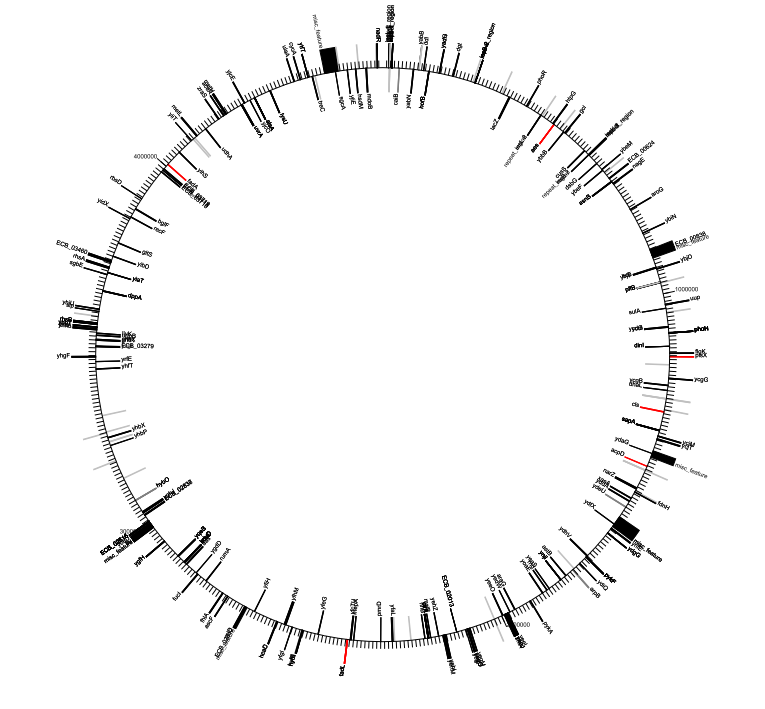

In [15]:
plot_GenomeDiagram('IS150', 'I')
Image(storage+'test_GenomeDiagram_IS150_I.png')

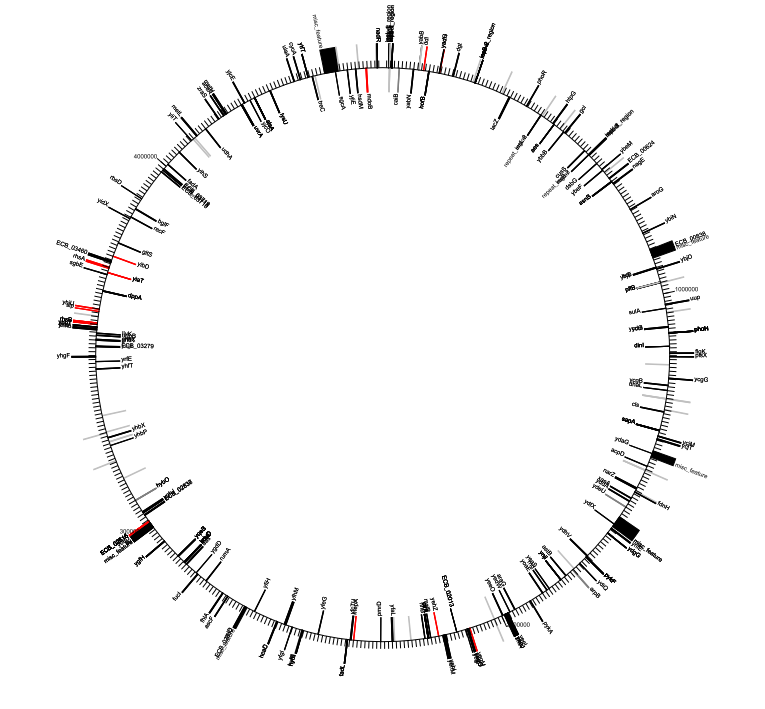

In [10]:
plot_GenomeDiagram('IS150', 'M')
Image(storage+'test_GenomeDiagram_IS150_M.png')

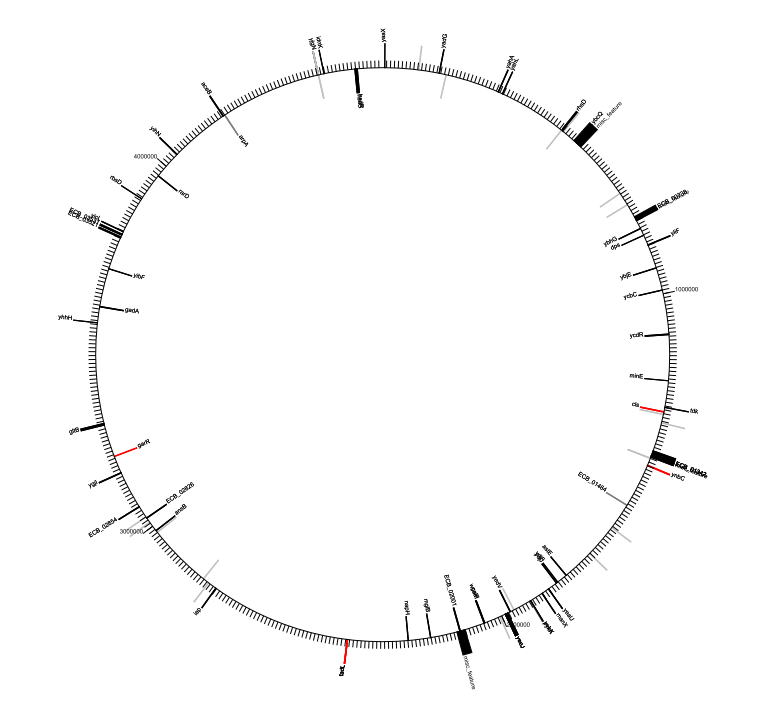

In [11]:
plot_GenomeDiagram('IS1', 'I')
Image(storage+'test_GenomeDiagram_IS1_I.png')

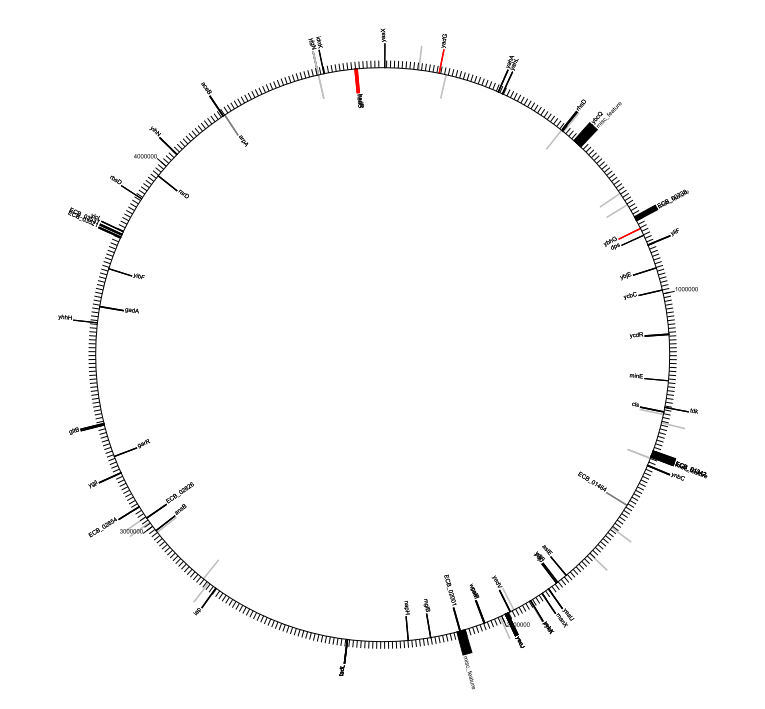

In [13]:
plot_GenomeDiagram('IS1', 'V')
Image(storage+'test_GenomeDiagram_IS1_V.png')

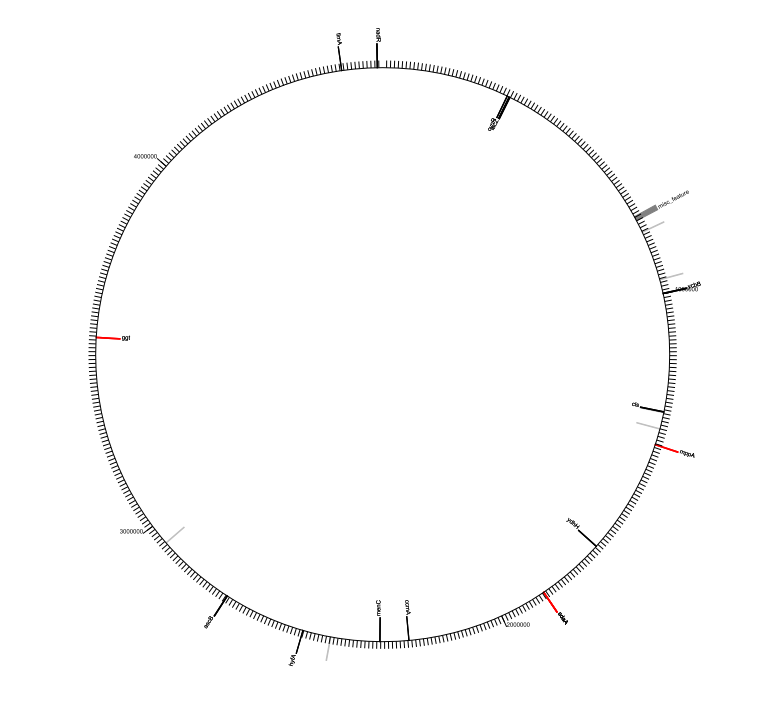

In [14]:
plot_GenomeDiagram('IS186', 'E')
Image(storage+'test_GenomeDiagram_IS186_E.png')

## Next step: adding GC content to the map

In [6]:
from colour import Color # importing package to do a colour gradient
number_colors1 = len(range(-23, 1, 1)) # I need colors to go from the min GC value to the average GC value...
number_colors2 = len(range(0, 16, 1)) # ... and from the average GC value to the max GC value, with a step of 0.01 GC fraction (1%)
start = Color("blue")
middle = Color("white")
end = Color("red")
colors1 = list(start.range_to(middle,number_colors1)) #creating a gradient from blue to white
colors2 = list(middle.range_to(end,number_colors2)) #creating a gradient from white to red
colors = colors1+colors2[1:] #merging the two into one color gradient

In [7]:
def calc_gc_content(sequence):
    """Return the % G+C content in a passed sequence.
    Arguments:
        - sequence  - a Bio.Seq.Seq object.
    calc_gc_content(sequence)
    """
    d = {}
    for nt in ["A", "T", "G", "C"]:
        d[nt] = sequence.count(nt) + sequence.count(nt.lower())
    gc = d.get("G", 0) + d.get("C", 0)

    if gc == 0:
        return 0
    # print(gc*100.0/(d['A'] +d['T'] + gc))
    return gc * 1.0 / (d["A"] + d["T"] + gc)

In [19]:
def plot_GenomeDiagram2(IS_name, category):

    positions_IS = extract_positions(IS_name)
    dict_cat_IS = extract_categories(positions_IS)

    gd_diagram = GenomeDiagram.Diagram('REL606') #creating the diagram
    gd_track_for_GC = gd_diagram.new_track(1, name = 'GC content') #adding a first track for the GC content (first ring)
    gd_feature_set_GC = gd_track_for_GC.new_set() #adding a list of features for the GC track
    gd_track_for_features = gd_diagram.new_track(2, name = 'Annotated Features') #adding a track for the features into which
    # an IS inserted
    gd_feature_set = gd_track_for_features.new_set() # creating a list of features to display on the second ring
    

    colors_dict = {'A': 'black', 'B':'black', 'C':'black', 'D':'black', 'E':'black', 'F':'black', 'G':'black', 'H':'black',
                   'I':'black', 'J':'black', 'K':'black', 'L':'black', 'M':'black', 'N':'black', 'O':'black',
                   'P':'black', 'Q':'black', 'R':'black', 'S':'black', 'T':'black' , 'U':'black', 'V':'black', 
                   'W':'black', 'Y':'black', 'Z':'black', 'unCOG':'black', 'intergenic_region':'grey'}
    
    colors_dict[category] = 'red' #only a given category will be highlighted in red

    len_IS = 1500 #could be changed for accuracy but not really necessary

    for insertion_position in list(dict_cat_IS.keys()): #for each insertion
        IS_position = int(insertion_position)
        position_found = False

        for feature in record.features[1:]: # we go through the features
            if feature.type == 'CDS': # we look at coding sequences
                if 'join' not in str(feature.location): #getting rid of an annoying but unique anomaly in the features
                    start_position = int(str(feature.location).split(':')[0][1:]) #we get the start of the CDS
                    end_position = int(str(feature.location).split(':')[1][:-4]) # we get the end of the CDS
                    if IS_position >= start_position and IS_position <= end_position: #if the IS interrupts the CDS
                        position_found = True
                        color = colors_dict[dict_cat_IS[insertion_position]]
                        # we add that feature to our second ring (set of genes interrupted by an IS)
                        gd_feature_set.add_feature(feature, color = color, label = True)

        if not position_found:
            # if no gene is interrupted, we create a feature: insertions that happen in intergenic regions
            new_feature = SeqFeature(FeatureLocation(IS_position,IS_position+len_IS), strand=int(positions_IS[insertion_position][1])) 
            gd_feature_set.add_feature(new_feature, color = 'grey', label = True)

    
    overall_gc = calc_gc_content(record.seq) #getting the GC percentage on the entire REL606 sequence
    for i in range(round(len(record.seq)/1000)): #for each window of 1000 bp
        start = i*1000 #getting the position corresponding to the beginning of the window
        finish = (i+1)*1000 #getting the position corresponding to the end of the window
        gc_content = calc_gc_content(record[start:finish].seq) #we calculate the GC percentage in this window
        skew = gc_content - overall_gc #we calculate the difference with the genome of REL606 overall
        color_index = round((round(skew, 2)+0.23)*100) #we get the corresponding color index
        color = colors[color_index].hex #we get the name of the color in the gradient list we generated
        new_feature = SeqFeature(FeatureLocation(start,finish), strand=+1) 
        # we create a feature for that 1000 bp window on our GC ring
        gd_feature_set_GC.add_feature(new_feature, color = color, label = False)
        # the color corresponds to the GC content skew compared to the overall genome
    
    #we create and save the diagram
    gd_diagram.draw(format = 'circular', circular = True, pagesize = (25*cm, 27*cm), start = 0, end = len(record), circle_core = 0.5)
    gd_diagram.write(storage+'test_GenomeDiagram'+'_'+ IS_name + '_' + category +'.pdf', 'PDF')
    gd_diagram.write(storage+'test_GenomeDiagram' +'_'+ IS_name + '_' + category + '.png', 'PNG')


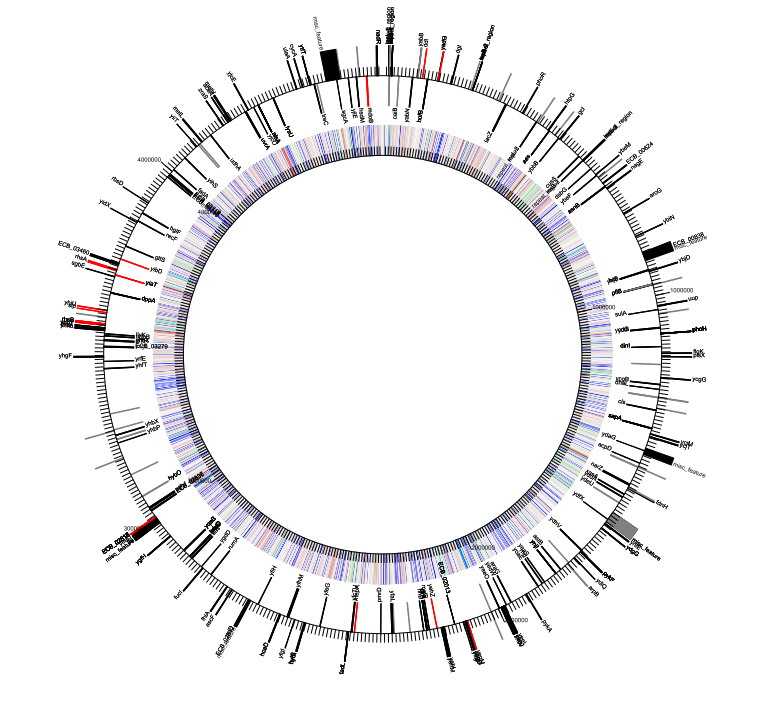

In [20]:
plot_GenomeDiagram2('IS150','M')
Image(storage+'test_GenomeDiagram_IS150_M.png')

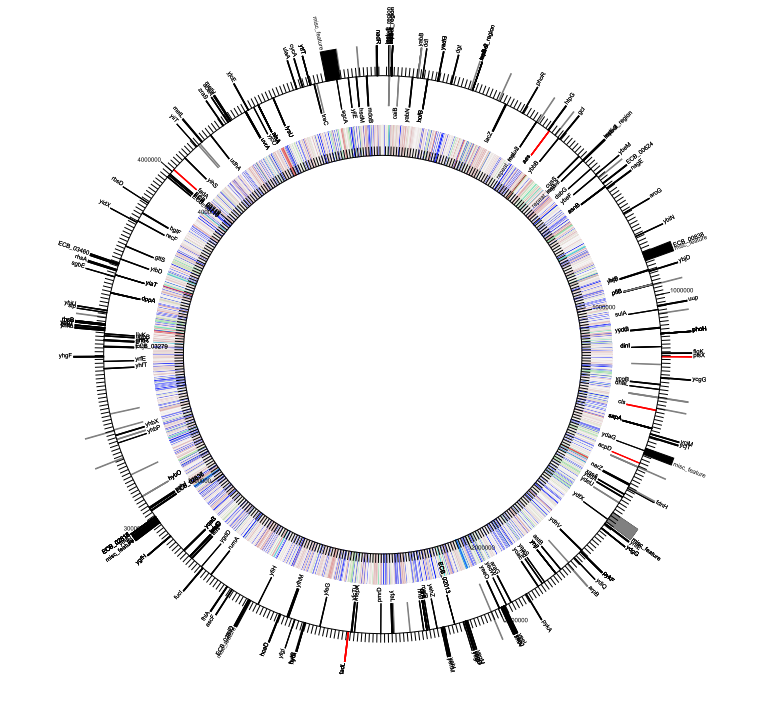

In [22]:
plot_GenomeDiagram2('IS150','I')
Image(storage+'test_GenomeDiagram_IS150_I.png')

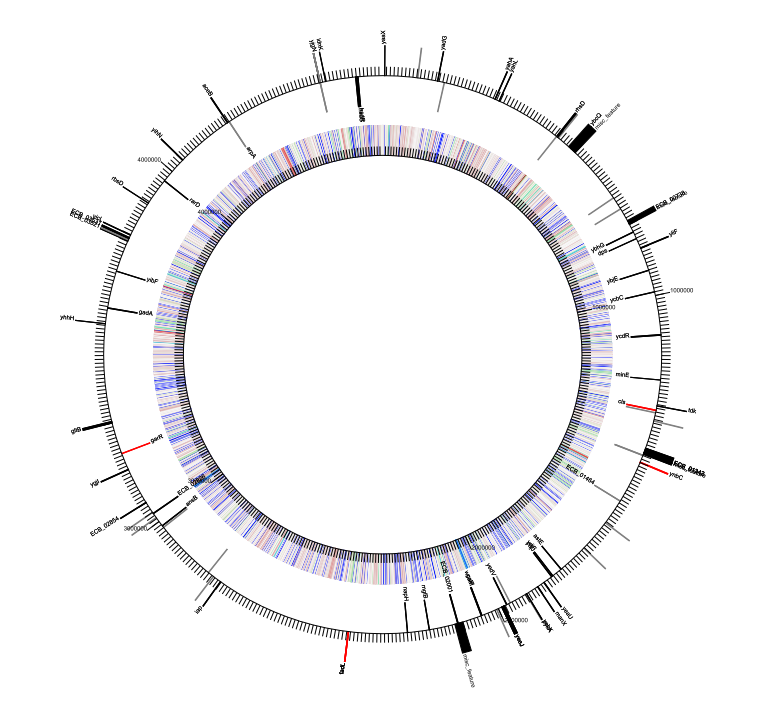

In [23]:
plot_GenomeDiagram2('IS1','I')
Image(storage+'test_GenomeDiagram_IS1_I.png')

In [ ]:
plot_GenomeDiagram2('IS1','V')

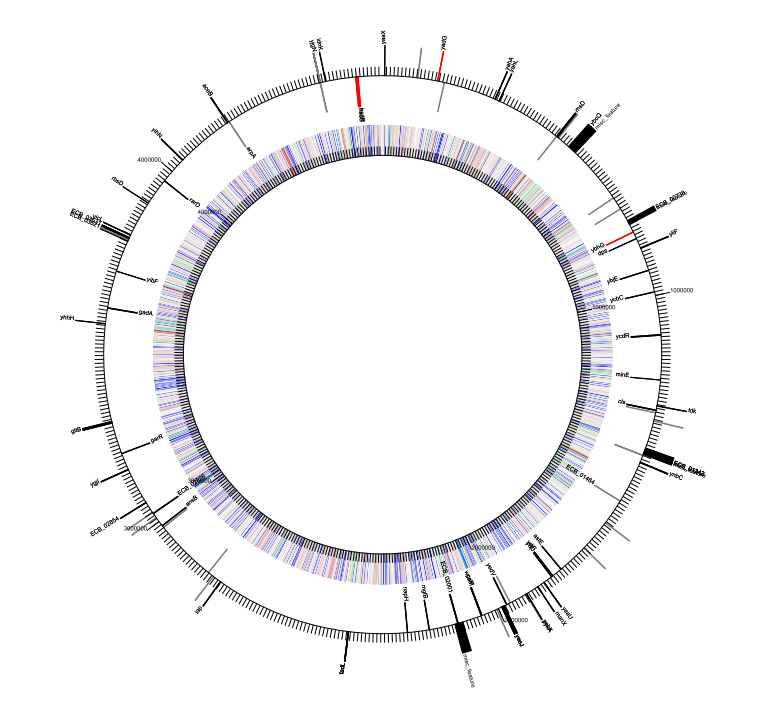

In [26]:
Image(storage+'test_GenomeDiagram_IS1_V.png')

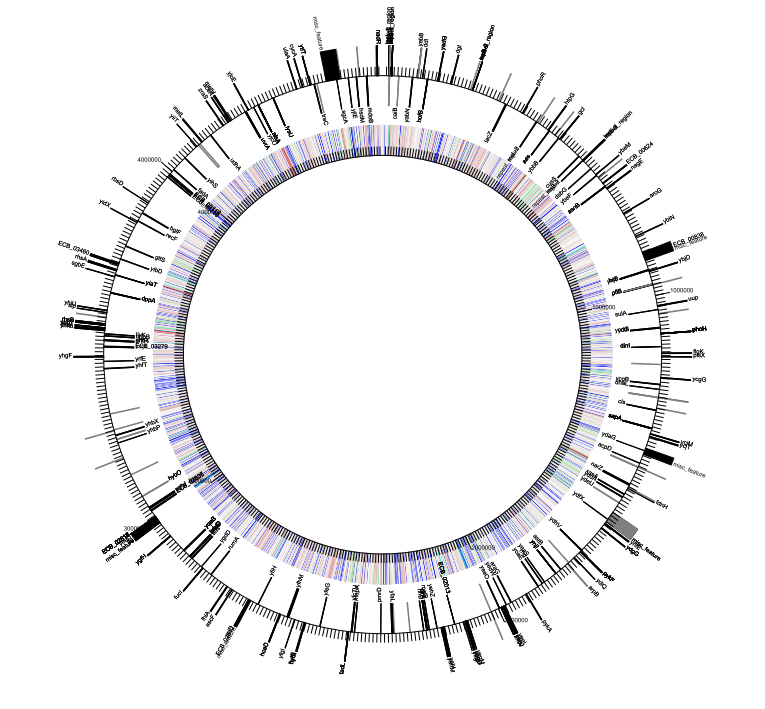

In [27]:
plot_GenomeDiagram2('IS150','_')
Image(storage+'test_GenomeDiagram_IS150__.png')

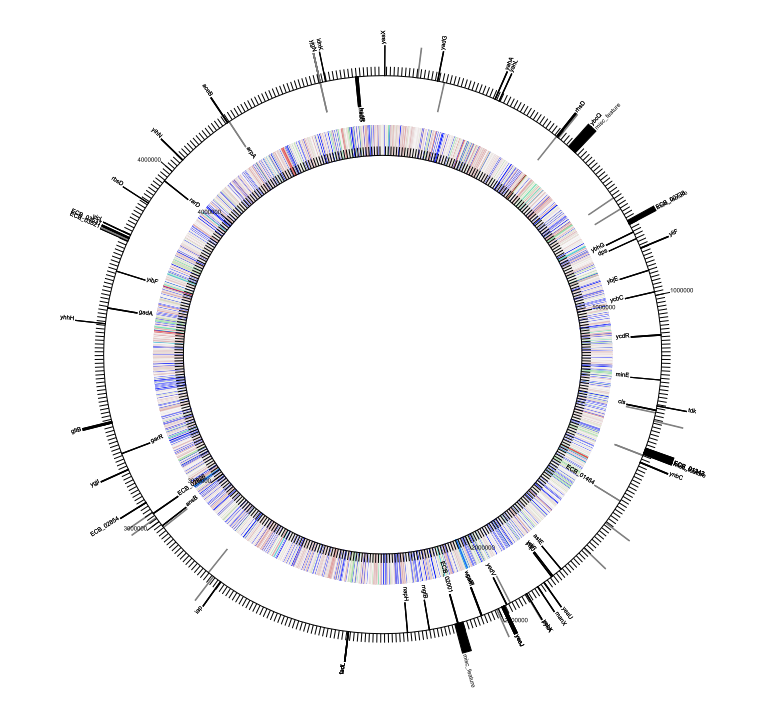

In [28]:
plot_GenomeDiagram2('IS1','_')
Image(storage+'test_GenomeDiagram_IS1__.png')

In [ ]:
def plot_GenomeDiagram2(IS_name, category):

    positions_IS = extract_positions(IS_name)
    dict_cat_IS = extract_categories(positions_IS)

    gd_diagram = GenomeDiagram.Diagram('REL606') #creating the diagram
    gd_track_for_GC = gd_diagram.new_track(1, name = 'GC content') #adding a first track for the GC content (first ring)
    gd_feature_set_GC = gd_track_for_GC.new_set() #adding a list of features for the GC track
    gd_track_for_features = gd_diagram.new_track(2, name = 'Annotated Features') #adding a track for the features into which
    # an IS inserted
    gd_feature_set = gd_track_for_features.new_set() # creating a list of features to display on the second ring
    

    colors_dict = {'A': 'black', 'B':'black', 'C':'black', 'D':'black', 'E':'black', 'F':'black', 'G':'black', 'H':'black',
                   'I':'black', 'J':'black', 'K':'black', 'L':'black', 'M':'black', 'N':'black', 'O':'black',
                   'P':'black', 'Q':'black', 'R':'black', 'S':'black', 'T':'black' , 'U':'black', 'V':'black', 
                   'W':'black', 'Y':'black', 'Z':'black', 'unCOG':'black', 'intergenic_region':'grey'}
    
    colors_dict[category] = 'red' #only a given category will be highlighted in red

    len_IS = 1500 #could be changed for accuracy but not really necessary

    for insertion_position in list(dict_cat_IS.keys()): #for each insertion
        IS_position = int(insertion_position)
        position_found = False

        for feature in record.features[1:]: # we go through the features
            if feature.type == 'CDS': # we look at coding sequences
                if 'join' not in str(feature.location): #getting rid of an annoying but unique anomaly in the features
                    start_position = int(str(feature.location).split(':')[0][1:]) #we get the start of the CDS
                    end_position = int(str(feature.location).split(':')[1][:-4]) # we get the end of the CDS
                    if IS_position >= start_position and IS_position <= end_position: #if the IS interrupts the CDS
                        position_found = True
                        color = colors_dict[dict_cat_IS[insertion_position]]
                        # we add that feature to our second ring (set of genes interrupted by an IS)
                        gd_feature_set.add_feature(feature, color = color, label = True)

        if not position_found:
            # if no gene is interrupted, we create a feature: insertions that happen in intergenic regions
            new_feature = SeqFeature(FeatureLocation(IS_position,IS_position+len_IS), strand=int(positions_IS[insertion_position][1])) 
            gd_feature_set.add_feature(new_feature, color = 'grey', label = True)

    
    overall_gc = calc_gc_content(record.seq) #getting the GC percentage on the entire REL606 sequence
    for i in range(round(len(record.seq)/1000)): #for each window of 1000 bp
        start = i*1000 #getting the position corresponding to the beginning of the window
        finish = (i+1)*1000 #getting the position corresponding to the end of the window
        gc_content = calc_gc_content(record[start:finish].seq) #we calculate the GC percentage in this window
        skew = gc_content - overall_gc #we calculate the difference with the genome of REL606 overall
        color_index = round((round(skew, 2)+0.23)*100) #we get the corresponding color index
        color = colors[color_index].hex #we get the name of the color in the gradient list we generated
        new_feature = SeqFeature(FeatureLocation(start,finish), strand=+1) 
        # we create a feature for that 1000 bp window on our GC ring
        gd_feature_set_GC.add_feature(new_feature, color = color, label = False)
        # the color corresponds to the GC content skew compared to the overall genome
    
    #we create and save the diagram
    gd_diagram.draw(format = 'circular', circular = True, pagesize = (25*cm, 27*cm), start = 0, end = len(record), circle_core = 0.5)
    gd_diagram.write(storage+'test_GenomeDiagram'+'_'+ IS_name + '_' + category +'.pdf', 'PDF')
    gd_diagram.write(storage+'test_GenomeDiagram' +'_'+ IS_name + '_' + category + '.png', 'PNG')
